# Efficient quantum algorithm for dissipative nonlinear differential equations

Original authors of paper and code (MATLAB): in-Peng Liu, Herman Øie Kolden, Hari K. Krovi, Nuno F. Loureiro, Konstantina Trivisa, Andrew M. Childs.

Pre-print: https://arxiv.org/abs/2011.03185 has official MATLAB code to reproduce results from the paper in https://github.com/hermankolden/CarlemanBurgers

Author of notebook: Óscar Amaro (2023)

In this notebook we convert the code into Python.

For __MATLAB__ users: https://numpy.org/doc/stable/user/numpy-for-matlab-users.html

__Python documentation__:
- Sparse matrices: https://docs.scipy.org/doc/scipy/reference/sparse.html
- Kronecker product: https://numpy.org/doc/stable/reference/generated/numpy.kron.html
- ODE solver: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
- PDE solver: https://py-pde.readthedocs.io/en/latest/

> To use py-pde, ```pip install pde h5py pandas pyfftw tqdm```

In [1]:
import numpy as np
from numpy import exp, log, sqrt, cos, sin, pi
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.integrate import solve_ivp
from tqdm import tqdm, trange
import json
from pde import CartesianGrid, MemoryStorage, PDEBase, ScalarField, plot_kymograph

In [12]:
# Takes the Kronecker power of a matrix
def kronp(A,k):
    B = 1;
    for i in range(k):
        B = np.kron(B, A);
    return B

# Simulation parameters
nx = 16; # Spatial discretization for Euler's method
nt = 4000; # Temporal discretization for Euler's method
nx_pde = 100; # Spatial discretization for the pdepe solver
nt_pde = 8000; # Temporal discretization for the pdepe solver, originally 40000

Re0 = 20; # Desired Reynolds number
L0 = 1; # Domain length
U0 = 1/sqrt(nx-1); # Initial maximum velocity
beta = 0; # Linear damping coefficient
f = 1; # Number of oscillations of the sinusoidal initial condition inside the domain
T = 3; # Simulation time

# driver source
def F0_fun(t,x): return U0*exp(-(x-L0/4)**2/(2*(L0/32)**2)) * cos(2*pi*t); # Source function.

N_max = 4; # Maximum Carleman truncation level
ode_deg = 2; # Degree of the Carleman ODE, should not be changed

# Initialize
Ns = np.arange(1,N_max+1,1); # Truncation levels

nu = U0*L0/Re0; # Viscosity
Tnl = L0/U0; # Nonlinear time
t_plot = Tnl/3; # Time to plot solution

# Spatial domain edges
x0 = -L0/2;
x1 = L0/2;

# Temporal domain edges
t0 = 0;
t1 = T;

# Euler's method discretization interval sizes and domains
dx = (x1-x0)/(nx-1);
dt = (t1-t0)/(nt-1);
xs = np.linspace(x0,x1,nx);
ts = np.linspace(t0,t1,nt);

# ode45 discretization
nt_ode = nt*10; # Make it more accurate than the Euler solution
dt_ode = (t1-t0)/(nt_ode-1);
ts_ode = np.linspace(t0,t1,nt_ode);

# pdepe discretization interval sizes
dx_pde = (x1-x0)/(nx_pde-1); # Spatial discretization interval size for pdepe solver
dt_pde = (t1-t0)/(nt_pde-1);
xs_pde = np.linspace(x0,x1,nx_pde);
ts_pde = np.linspace(t0,t1,nt_pde);

# Discretize Burger's equation
F0 = np.zeros((nt,nx));
for it in range(nt):
    F0[it,:] = F0_fun(ts[it],xs);

# F1
F1 = np.zeros((nx,nx)); #F1 = np.zeros((nx,nx));
for i in range(nx):
    if i>0:
        F1[i,i-1] = nu/dx**2;
    if i<nx-1:
        F1[i,i+1] = nu/dx**2;
    F1[i,i] = -2*nu/dx**2;
F1 = F1 - beta*np.identity(nx); # Add linear damping if present

# F2
F2 = np.zeros(nx**3);
F2[(nx**2+nx):-1:(nx**2+nx+1)] = -1/(4*dx);
F2[1:-1:(nx**2+nx+1)] = +1/(4*dx);
F2 = np.reshape(F2,(nx**2,nx)); # np.sum(F2 != 0) = 256 for nx=16
F2 = F2.transpose()
# Enforce the Dirichlet boundaries within the domain.
# F0(1) = 0;
# F0(end) = 0;

F1[0,:] = 0;
F1[-1,:] = 0;
F2[0,:] = 0;
F2[-1,:] = 0;

# Initial condition
def u0(x): return -U0*sin(2*pi*f*x/L0);
u0s = u0(xs);

In [13]:
# ODE for ode45 solver
#F0_interp_aux = interpolate.interp1d(ts,F0);
#def F0_interp(t):
#    return F0_interp_aux(ts,F0,t)
def burgers_odefun(t,u):
    return F0_fun(t,xs) + np.matmul(F1,u) + np.matmul(F2,np.kron(u,u));

# PDE, initial condition and boundary condition for pdepe solver
def burger_pde(x,t,u,dudx): return 1, nu*dudx-u**2/2, -beta*u + F0_fun(t,x);
burger_ic = u0;
def burger_bc(xl, ul, xr, ur, t): return ul, 0, ur, 0;

# Check CFL condition

# Dissipative and advective CFL numbers for Euler's method and pdepe
C1_e = U0*dt/dx;
C2_e = 2*nu*dt/dx**2;
C1_ode = U0*dt_ode/dx;
C2_ode = 2*nu*dt_ode/dx**2;
C1_pde = U0*dt_pde/dx_pde;
C2_pde = 2*nu*dt_pde/dx_pde**2;
if C1_e > 1:
    error(sprintf("C1_e = %.2f\n",C1_e));
if C2_e > 1:
    error(sprintf("C2_e = %.2f\n",C2_e));
if C1_ode > 1:
    error(sprintf("C1_ode = %.2f\n",C1_ode));
if C2_ode > 1:
    error(sprintf("C2_ode = %.2f\n",C2_ode));
if C1_pde > 1:
    error(sprintf("C1_pde = %.2f\n",C1_pde));
if C2_pde > 1:
    error(sprintf("C2_pde = %.2f\n",C2_pde));

# Calculate the Carleman convergence number
lambdas, _ = LA.eig(F1);
#print(lambdas)
lambdas = lambdas[lambdas != 0];
lbd = np.max(lambdas);

f2 = LA.norm(F2);
f1 = LA.norm(F1);
f0 = 0.0;
for it in range(nt):
    f0 = np.max([LA.norm(F0[it,:]),f0]);
R = (LA.norm(u0s)*f2+f0/LA.norm(u0s))/np.abs(lbd);

#r1 = (np.abs(lbd)-sqrt(lbd**2-4*f2*f0))/(2*f2); # these values are not used
#r2 = (np.abs(lbd)+sqrt(lbd**2-4*f2*f0))/(2*f2); #

if dt > 1/(N_max*f1):
    print('Time step too large'); exit();

if f0 + f2 > np.abs(lbd):
    print('Perturbation too large\n');

# Prepare Carleman matrix

print('Preparing Carleman matrix\n');

# Calculate matrix block sizes
dNs = np.zeros(N_max);
for N in Ns:
    dNs[N-1] = (nx**(N+1)-nx)/(nx-1);

Perturbation too large

Preparing Carleman matrix



In [14]:
# Solve direct Euler
print('Solving direct Euler\n');
us_e = np.zeros((nt,nx));
us_e[0,:] = u0s;
#
for k in trange(nt-1):
    us_e[k+1,:] = us_e[k,:] + dt*burgers_odefun(ts[k],us_e[k,:]);
    
# Solve "exact" ODE
print('Solving "exact" ODE\n');
# scipy.integrate.solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
sol = solve_ivp(fun=burgers_odefun, t_span=[0, np.max(ts_ode)], y0=u0s, method='RK45', rtol=1e-10, atol=1e-10)
ts_ode, us_ode = sol.t, sol.y
#
# Interpolate so we can compare with other solutions
us_d_aux = interpolate.interp1d(ts_ode,us_ode);
us_d = us_d_aux(ts);

Solving direct Euler



100%|█████████████████████████████████████| 3999/3999 [00:00<00:00, 9705.79it/s]


Solving "exact" ODE



In [15]:
print('Solving "exact" PDE\n');
class BurgersPDE(PDEBase):
    """py-pde Burger's equation"""
    def evolution_rate(self, state, t=0):
        """implement the python version of the evolution equation"""
        assert state.grid.dim == 1  # ensure the state is one-dimensional
        u = state
        grad_x = state.gradient("auto_periodic_neumann")[0]
        return -u*grad_x + nu*u.laplace("auto_periodic_neumann") + F0_fun(t,xs_pde) #"auto_periodic_neumann"

# initialize the equation and the space
grid = CartesianGrid([[-0.5, 0.5]], [len(xs_pde)], periodic=True)
state = ScalarField.from_expression(grid, "-{}*sin(2*pi*x)".format(U0))

# solve the equation and store the trajectory
eq = BurgersPDE()

storage = MemoryStorage()
eq.solve(state, t_range=T, dt=(T/(len(ts_pde)-1)), tracker=[storage.tracker((T/(len(ts_pde)-1)))])
#plot_kymograph(storage)
us_pde = np.array(storage.data)

# Interpolate so we can compare with other solutions.
# First interpolate over space, and then over time.
us_pde_interp_temp = np.zeros((nt,nx_pde));
for i in trange(nx_pde):
    intaux = interpolate.interp1d(ts_pde,us_pde[:,i]);
    us_pde_interp_temp[:,i] = intaux(ts)
#
us_pde_interp = np.zeros((nt,nx));
for k in trange(nt):
    intaux = interpolate.interp1d(xs_pde,us_pde_interp_temp[k,:]);
    us_pde_interp[k,:] = intaux(xs)

Solving "exact" PDE



100%|█████████████████████████████████████| 4000/4000 [00:00<00:00, 8190.74it/s]


In [ ]:
m2 = sps.csr_matrix(([3,0], ([2,1], [1,3])), dtype=np.float)
m2.eliminate_zeros()
m2.todense()

In [ ]:
# First prepare the Carleman system with just the source term at t=0
A = spalloc(dNs(end),dNs(end),dNs(end)*nx);
Fs = [F0_fun(1,xs)' F1 F2];
for i in Ns[0]:
    for j = 0:min(ode_deg,N_max-i+1):
        if (i == 1) and (j == 0):
            continue;
        a0 = 1+(nx^i-nx)/(nx-1);
        a1 = a0 + nx^i-1;
        b0 = 1+(nx^(j+i-1)-nx)/(nx-1);
        b1 = b0 + nx^(j+i-1)-1;

        Aij = spalloc(nx^i,nx^(i+j-1),nx^(i+j-1+1));
        f0 = 1+(nx^j-nx)/(nx-1)+1;
        f1 = f0+nx^j-1;
        Fj = Fs(:,f0:f1);

        for p in range(i):
            Ia = kronp(sparse(np.identity(nx)), p-1);
            Ib = kronp(sparse(np.identity(nx)), i-p);
            Aij = Aij + np.kron(np.kron(Ia, Fj), Ib);
        
        A[a0:a1,b0:b1] = Aij;

In [ ]:
# Solve Carleman system
ys_c_N = np.zeros((N_max,nt,dNs[N_max]);
for N in Ns[0]:
    A_N = A(1:dNs(N),1:dNs(N));
    b_N = np.zeros(dNs[N]);

    b_N[0:nx] = F0_fun(1,xs);
    y0s = [];
    for i in range(N):
        y0s = [y0s, kronp(u0s,i)];

    print('Solving Carleman N=%d\n',N);

    ys = np.zeros((nt,dNs[N-1]));
    ys(1,:) = y0s;
    for k = 1:(nt-1)
        # Rebuild the inhomogeneous part of the Carleman matrix per time
        # step
        for i in range(2,N):
            a0 = 1+(nx^i-nx)/(nx-1);
            a1 = a0 + nx^i-1;
            b0 = 1+(nx^(i-1)-nx)/(nx-1);
            b1 = b0 + nx^(i-1)-1;

            Aij = spalloc(nx^i,nx^(i-1),nx^i);
            Fj = F0_fun(ts(k),xs)';

            for p in range(i):
                Ia = kronp(sparse(eye(nx)), p-1);
                Ib = kronp(sparse(eye(nx)), i-p);
                Aij = Aij + kron(kron(Ia, Fj), Ib);
                  
            A_N(a0:a1,b0:b1) = Aij;
                  
        b_N(1:nx) = F0_fun(ts(k),xs);
        ys(k+1,:) = ys(k,:) + dt*(A_N*ys(k,:) + b_N);
                                  
    print('Done\n',N);
    ys_c_N(N,:,1:dNs(N)) = real(ys(:,:));
us_c_N = ys_c_N(:,:,1:nx);

In [ ]:
# Calculate errors
dus_c_d_N = np.zeros((N_max,nt,nx));
dus_rel_c_d_N = np.zeros((N_max,nt,nx));
eps_c_d_N = np.zeros((N_max,nt));
eps_rel_c_d_N = np.zeros((N_max,nt));

dus_c_pde_N = np.zeros((N_max,nt,nx));
dus_rel_c_pde_N = np.zeros((N_max,nt,nx));
eps_c_pde_N = np.zeros((N_max,nt));
eps_rel_c_pde_N = np.zeros((N_max,nt));

dus_d_pde = np.zeros((nt,nx));
dus_rel_d_pde = np.zeros((nt,nx));
eps_d_pde = np.zeros((1,nt));
eps_rel_d_pde = np.zeros((1,nt));

dus_d_e = np.zeros((nt,nx));
dus_rel_d_e = np.zeros((nt,nx));
eps_d_e = np.zeros((1,nt));
eps_rel_d_e = np.zeros((1,nt));

for N in range(N_max):
    dus_c_d_N(N,:,:) = reshape(us_c_N(N,:,:),nt,nx)-us_d(:,:);
    dus_rel_c_d = reshape(dus_c_d_N(N,:,:),nt,nx)./us_d(:,:);
    dus_rel_c_d(isnan(dus_rel_c_d)) = 0;
    dus_rel_c_d_N(N,:,:) = dus_rel_c_d;

    dus_c_pde_N(N,:,:) = reshape(us_c_N(N,:,:),nt,nx)-us_pde_interp(:,:);
    dus_rel_c_pde = reshape(dus_c_pde_N(N,:,:),nt,nx)./us_pde_interp(:,:);
    dus_rel_c_pde(isnan(dus_rel_c_pde)) = 0;
    dus_rel_c_pde(isinf(dus_rel_c_pde)) = 0;
    dus_rel_c_pde_N(N,:,:) = dus_rel_c_pde;

    dus_d_pde(:,:) = reshape(us_d(:,:),nt,nx)-us_pde_interp(:,:);
    dus_rel_d_pde = reshape(dus_d_pde(:,:),nt,nx)./us_pde_interp(:,:);
    dus_rel_d_pde(isnan(dus_rel_d_pde)) = 0;
    dus_rel_d_pde(isinf(dus_rel_d_pde)) = 0;

    dus_d_e(:,:) = reshape(us_d(:,:),nt,nx)-us_e(:,:);
    dus_rel_d_e = reshape(dus_d_e(:,:),nt,nx)./us_e(:,:);
    dus_rel_d_e(isnan(dus_rel_d_e)) = 0;
    dus_rel_d_e(isinf(dus_rel_d_e)) = 0;

    for k in range(nt):
        eps_c_d_N[N,k] = LA.norm(reshape(dus_c_d_N(N,k,:),nx,1));
        eps_rel_c_d_N[N,k] = LA.norm(reshape(dus_rel_c_d_N(N,k,:),nx,1),ord=np.inf);

        eps_c_pde_N[N,k] = LA.norm(reshape(dus_c_pde_N(N,k,:),nx,1));
        eps_rel_c_pde_N[N,k] = LA.norm(reshape(dus_rel_c_pde_N(N,k,:),nx,1),ord=np.inf);

        eps_d_pde[k] = LA.norm(reshape(dus_d_pde(k,:),nx,1));
        eps_rel_d_pde[k] = LA.norm(reshape(dus_rel_d_pde(k,:),nx,1),ord=np.inf);

        eps_d_e[k] = LA.norm(reshape(dus_d_e(k,:),nx,1));
        eps_rel_d_e[k] = LA.norm(reshape(dus_rel_d_e(k,:),nx,1),ord=np.inf);

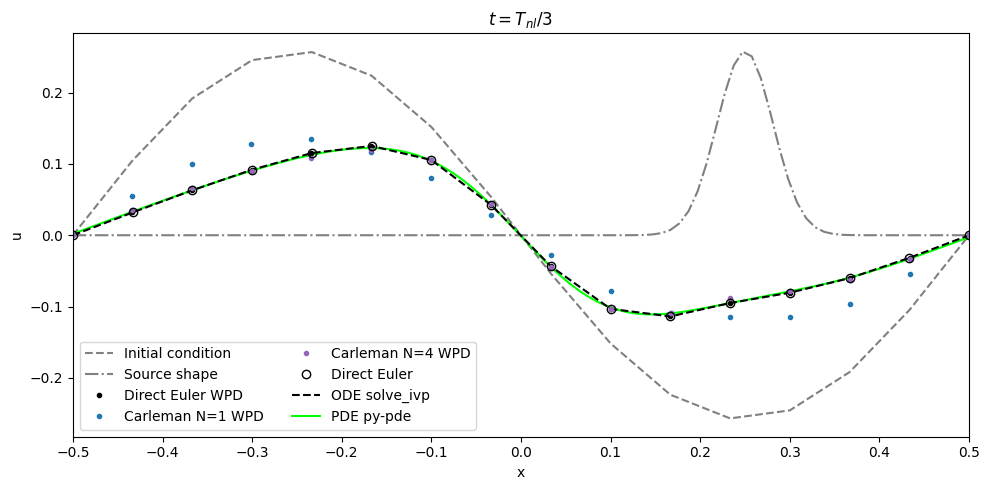

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Find indices for which we will plot the solution
i_plot = (np.where(ts>=t_plot)[0])[0];
i_plot_pde = (np.where(ts_pde>=t_plot)[0])[0];
i_start = np.ceil(i_plot*3/4);

# Plot Initial condition and solution at third nonlinear time
plt.plot(xs, u0s, '--', label=r'Initial condition', color='gray', zorder=-999);
plt.plot(xs_pde, F0_fun(0,xs_pde), '-.', label=r'Source shape', color='gray', zorder=-999);

# WPD data
f = open('dataWPD/Fig1a/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', color='black', label='Direct Euler WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', color='tab:blue', label='Carleman N=1 WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', color='tab:purple', label='Carleman N=4 WPD')

plt.plot(xs, us_e[i_plot,:],'ko', label=r'Direct Euler', markerfacecolor='none');
plt.plot(xs, us_d[:,i_plot],'k--', label=r'ODE solve_ivp', zorder=-99);
plt.plot(xs_pde, us_pde[i_plot_pde,:], color='lime', label=r'PDE py-pde', zorder=-999)
"""
for N = [Ns(1) Ns(end)]
    ax.ColorOrderIndex = N;
    plot(xs,reshape(ys_c_N(N,i_plot,1:nx),nx,1),'-*','DisplayName',sprintf('Carleman at $T_{nl}/3$, $N=%d$',N));
ylim([-max(abs(us_pde(1,:))), max(abs(us_pde(1,:)))]);
"""
plt.legend(ncol=2)
plt.title(r'$t=T_{nl}/3$')
plt.xlabel(r'x')
plt.ylabel(r'u')
plt.xlim([-0.5,+0.5])
plt.xticks(np.arange(-0.5,0.51,0.1))
plt.tight_layout()
plt.show()

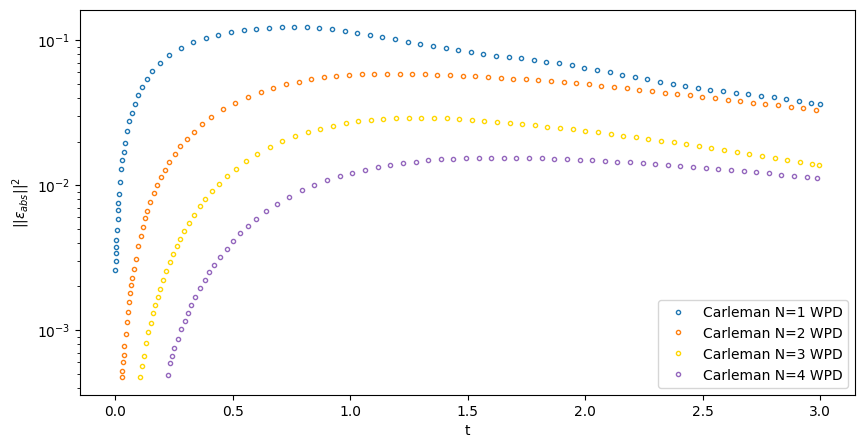

In [78]:
# Error of each Carleman approach
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

f = open('dataWPD/Fig1b/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markerfacecolor='none', color='tab:blue', label='Carleman N=1 WPD')
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markerfacecolor='none', color='tab:orange', label='Carleman N=2 WPD')
# 
datatmp = data['datasetColl'][2]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markerfacecolor='none', color='gold', label='Carleman N=3 WPD')
# 
datatmp = data['datasetColl'][3]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'.', markerfacecolor='none', color='tab:purple', label='Carleman N=4 WPD')

plt.legend()
plt.xlabel(r't')
plt.ylabel(r'$||\epsilon_{abs}||^2$')
plt.yscale('log')
plt.show()

In [ ]:
# Plotting configuration
set(groot, 'defaultAxesTickLabelInterpreter','latex'); set(groot, 'defaultLegendInterpreter','latex');
fontsize = 14;

# Plot Initial condition and solution at half nonlinear time
ax = subplot(2,2,1:2);
plt.plot(xs_pde,us_pde(1,:),'k--','DisplayName',sprintf('Initial condition'));
plt.plot(xs_pde,F0_fun(1,xs_pde),'k-.','DisplayName',sprintf('Source shape'));
plt.plot(xs,us_d(i_plot,:),'k-o','DisplayName',sprintf('Direct Euler solution at $T_{nl}/3$'));
for N = [Ns(1) Ns(end)]
    ax.ColorOrderIndex = N;
    plot(xs,reshape(ys_c_N(N,i_plot,1:nx),nx,1),'-*','DisplayName',sprintf('Carleman solution at $T_{nl}/3$, $N=%d$',N));
plt.ylim([-max(abs(us_pde(1,:))), max(abs(us_pde(1,:)))]);

# Plot absolute l_2 error between Carleman and direct solution
for N = Ns:
    ax = subplot(2,2,3);
    ax.ColorOrderIndex = N;
    plt.semilogy(ts,eps_c_d_N(N,:),'DisplayName',sprintf('Carleman, $N=%d$',N));

# Plot time-maximum absolute l_2 error between Carleman and pdepe
ax = subplot(2,2,4);
plt.semilogy(Ns, max(eps_c_d_N,[],2),'-o','DisplayName',sprintf('Time-maximum error'));

# Format initial condition plot
subplot(2,2,1:2);
plt.xlabel('$x$');
plt.ylabel('$u$');
plt.xlim([x0 x1]);
lgd = legend();
set(lgd,'fontsize',fontsize-4);
set(gca,'fontsize',fontsize);

# Format absolute l_2 error plot
subplot(2,2,3);
plt.title(sprintf('Absolute error'), 'interpreter','latex');
plt.xlabel('$t$', 'interpreter','latex');
plt.ylabel('$\|\varepsilon_{\mathrm{abs}}\|_2$', 'interpreter','latex');
xline(t_plot,':','DisplayName','T_{nl}/3', 'HandleVisibility', 'Off');
plt.ylim([min([min(eps_c_d_N(:,i_start:end)),eps_d_pde(i_start:end)])*0.1 max(eps_c_d_N(1,:))*10]);
lgd = legend();
set(lgd,'fontsize',fontsize-4);
set(gca,'fontsize',fontsize);

ax = gca;
xruler = ax.XRuler;
old_fmt = xruler.TickLabelFormat;
old_xticks = xruler.TickValues;
old_labels = sprintfc(old_fmt, old_xticks);
new_tick = t_plot;
new_label = sprintf(['%s%d%s' old_fmt],'$T_{\mathrm{nl}}/3$');
all_xticks = [old_xticks, new_tick];
all_xlabels = [old_labels, new_label];
[new_xticks, sort_order] = sort(all_xticks);
new_labels = all_xlabels(sort_order);
set(xruler, 'TickValues', new_xticks, 'TickLabels', new_labels);

# Format error convergence plot
subplot(2,2,4);
plt.title(sprintf('Error convergence'), 'interpreter','latex');
plt.xlabel('$N$', 'interpreter','latex');
plt.ylabel('$\max_t \|\varepsilon_{\mathrm{abs}}\|_2$', 'interpreter','latex');
ax = gca;
lgd = legend();
set(gca,'fontsize',fontsize);
set(lgd,'fontsize',fontsize-4);

# Finalize and save
Re_act = max(max(us_pde))*L0/nu;
sgtitle(sprintf('Forced VBE solution with $\\mathrm{Re}=%.2f$, $n_x=%d$, $n_t=%d$, $\\mathrm{R}=%.2f$',Re_act,nx,nt, R), 'interpreter','latex', 'fontsize', fontsize+2);
#plt.savefig(sprintf('vbe_re0_%.2f_N_%d_nx_%d_nt_%d_rev2.fig',Re0,N_max,nx,nt));

plt.tight_layout()
plt.show()